In [11]:
"""
Modules - include all modules here
"""
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
import json
import os
import cv2
from pprint import pprint

In [12]:
"""
List of classes
"""

# DataElement Class
class DataElement:
    """
    This object contains variables for a single data
    @author: Kevin Jang (kj460)
    """
    label = None        # label (tag number) of this plate
    height = None       # height of this plate
    width = None        # width of this plate
    label_length = None # number of characters in this plate's label
    img = None          # parsed image
    tags = []           # data tags
    
    def __init__( self, label, height, width, label_length, img, tags ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.label = label
        self.height = height
        self.width = width
        self.label_length = label_length
        self.img = img
        self.tags = tags
    
    def __str__( self ):
        """
        Returns the value of each variable for this class
        @author: Kevin Jang (kj460)
        """
        return "\t** Values:\n\t\t* label : {}\n\t\t* height : {}\n\t\t* width : {}\n\t\t* label_length = {}\n\t\t* img = {}\n\t\t* tags = {}\n".format( self.label, self.height, self.width, self.label_length, self.img, self.tags )
    
    def __repr__(self):
        """
        @author: Kevin Jang (kj460)
        """
        return self.__str__()

# DataSet Class
class DataSet:
    """
    This object contains the list of DataElement for a single dataset
    @author: Kevin Jang (kj460)
    """
    data_path = None  # path of the directory that contains data files
    data = {}         # list of DataElement
    num_redundant = 0 # number of redundant data
    num_missing = 0   # number of missing data
    num_noisy = 0     # number of noisy data

    def __init__( self, data_path ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.data_path = data_path
    
    def __str__( self ):
        """
        Returns the state of each DataElement in the data list
        @author: Kevin Jang (kj460)
        """
        string = ""
        for label, data_elem in self.data.items():
            string += str( data_elem )
        return string
    
    def valid_json( self, json_data ):
        """
        Returns True if a given json_data is valid else return False
        @author: Kevin Jang (kj460)
        """
        if 'description' not in json_data or 'size' not in json_data or 'height' not in json_data[ 'size'] or 'width' not in json_data[ 'size' ] or 'tags' not in json_data or len( json_data[ 'tags' ] ) == 0:
            self.num_missing += 1
            return False
        elif len( json_data[ 'description' ] ) != 8 or int( json_data[ 'size' ][ 'width' ] ) != 152 or int( json_data[ 'size' ][ 'height' ] ) != 34:
            self.num_noisy += 1
            return False
        elif json_data[ 'description' ] in self.data.keys():
            self.num_redundant += 1
            return False
        else:
            return True
    
    def build_dataset( self, num_files ):
        """
        Reads data files and create DataElement for each data file and include it in the data list
        @author: Kevin Jang (kj460)
        @params:
            num_files - number of data files to be read; set this to 'None' to read all the files
        """
        ann_path = self.data_path + '/ann'
        img_path = self.data_path + '/img'
        count = 0
        for file in os.listdir( ann_path ):
            if num_files != None and count >= num_files:
                # stop reading
                break
            # file validation
            if '.json' not in file:
                continue
            # process JSON file
            json_file = open( ann_path + '/' + file )
            json_data = json.load( json_file )
            # data validation
            if not self.valid_json( json_data ):
                continue
            # create a new DataElement
            data_elem = DataElement( json_data[ 'description' ],
                                   json_data[ 'size' ][ 'height' ],
                                   json_data[ 'size' ][ 'width' ],
                                   len( json_data[ 'description' ] ),
                                   None,
                                   json_data[ 'tags' ] )
            # process PNG file
            img_file = cv2.imread( img_path + '/' + ( file.split( '.json' )[ 0 ] ) + '.png' )
            img_file = cv2.cvtColor( img_file, cv2.COLOR_BGR2GRAY )
            img_file = cv2.resize( img_file, ( data_elem.width, data_elem.height ) )
            img_file = img_file.astype( np.float32 ) / 255
            # add a new DataElement to the list
            data_elem.img = img_file
            self.data[ data_elem.label ] = data_elem
            count += 1
            
# TrainTestDataSet Class
class TrainTestDataSet:
    """
    This object contains DataSet for training and testing
    @author: Kevin Jang (kj460)
    """
    train_data_path = None # path of the directory that contains training data files
    test_data_path = None  # path of the directory that contains testing data files
    train_dataset = None   # training DataSet object
    test_dataset = None    # testing DataSet object
    
    def __init__( self, train_data_path, test_data_path ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        
    def __str__( self ):
        """
        Returns the string that contains information about training and testing dataset
        @author: Kevin Jang (kj460)
        """
        return '*** Training Set ***\n' + str( self.train_dataset ) + '\n*** Testing Set ***\n' + str( self.test_dataset )
    
    def build_train_test_dataset( self ):
        """
        Builds training and testing DataSet
        @author: Kevin Jang (kj460)
        """
        self.train_dataset = DataSet( self.train_data_path )
        self.train_dataset.build_dataset( None )
        self.test_dataset = DataSet( self.test_data_path )
        self.test_dataset.build_dataset( None )


In [13]:
# DataValidator Class
class DataValidator:
    '''
    Validator class to check the data cleanliness
    @author: Kevin Jang (kj460)
    '''
    train_test_dataset = None
    
    def __init__( self, train_test_dataset ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.train_test_dataset = train_test_dataset
        
    def __str__( self ):
        """
        Returns the string that contains information about validation on both training and testing dataset
        @author: Kevin Jang (kj460)
        """
        str = '*** DataSet Validation ***\n'
        str += '\t** Number of Redundant Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_redundant )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_redundant )
        str += '\t** Number of Missing Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_missing )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_missing )
        str += '\t** Number of Noisy Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_noisy )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_noisy )
        return str
        

In [14]:
# directiory that contains the data files
train_data_path = 'data/ANPR_OCR__train'
test_data_path = 'data/ANPR_OCR__test'

# create TrainTestDataSet
train_test_dataset = TrainTestDataSet( train_data_path, test_data_path )
train_test_dataset.build_train_test_dataset()

# print the dataset
# print( str( train_test_dataset ) )

In [15]:
# check the cleanliness of the dataset
data_validator = DataValidator( train_test_dataset )
print( str ( data_validator ) )

*** DataSet Validation ***
	** Number of Redundant Data
		* Training DataSet : 0
		* Testing DataSet : 0
	** Number of Missing Data
		* Training DataSet : 0
		* Testing DataSet : 0
	** Number of Noisy Data
		* Training DataSet : 0
		* Testing DataSet : 0



In [46]:
print(train_test_dataset.train_dataset.data['A327TK84'])

	** Values:
		* label : A327TK84
		* height : 34
		* width : 152
		* label_length = 8
		* img = [[0.8235294  0.5058824  0.38431373 ... 0.38431373 0.5058824  0.8235294 ]
 [0.28235295 0.2        0.09803922 ... 0.09803922 0.2        0.28235295]
 [0.09803922 0.09803922 0.29411766 ... 0.29411766 0.09803922 0.09803922]
 ...
 [0.1764706  0.09803922 0.12941177 ... 0.12941177 0.09803922 0.1764706 ]
 [0.58431375 0.15686275 0.09803922 ... 0.09803922 0.15686275 0.58431375]
 [0.7411765  0.7137255  0.6862745  ... 0.6862745  0.7137255  0.7411765 ]]
		* tags = ['train']



In [276]:
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Reshape, Lambda, LSTM, Dropout, Conv2D, MaxPooling2D, Embedding
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.recurrent import GRU
from keras.layers.merge import add, concatenate
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [282]:
sess = tf.Session()
K.set_session(sess)

In [288]:
char_set = set()
for key, value in train_test_dataset.train_dataset.data.items():
    for c in key:
        char_set.add(c)
char_list = sorted(list(char_set))

def text_to_indices(text):
    return list(map(lambda x: char_list.index(x), text))

def indices_to_text(indices):
    return ''.join(list(map(lambda x: char_list[int(x)], indices)))

def output_size():
    return len(char_list) + 1

def decoding_to_text(y):
    result = []
    for i in range(y.shape[0]):
        prev = -1
        max_index = 0
        s = ''
        for j in range(len(y[0])):
            for k in range(len(y[0][0])):
                if y[i][j][k] > y[i][j][max_index]:
                    max_index = k
            if max_index is not prev and max_index < len(char_list):
                #sublist.append(y[i][j][max_index])
                s = s + char_list[max_index]
            prev = max_index
        result.append(s)
    return result

In [284]:
X_train = []
y_train = []

for key, value in train_test_dataset.train_dataset.data.items():
    X_train.append(value.img)
    y_train.append(text_to_indices(key))

In [285]:
class TextImageGenerator:
    def __init__(self, ds, img_w, img_h, batch_size, downsample_factor, max_text_len=8):
        self.max_text_len = 8
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        self.samples = []
        for key, value in ds.data.items():
            self.samples.append(key)
            
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (key, value) in enumerate(ds.data.items()):
            self.imgs[i, :, :] = value.img
            self.texts.append(key)
        
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        img_h = 34
        img_w = 152
        while True:
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([8, 1, img_w, img_h])
            else:
                X_data = np.ones([8, img_w, img_h, 1])
        
            Y_data = np.ones([8, 8])
            input_length = np.ones((8, 1)) * (img_w // 4 - 2)
            label_length = np.zeros((8, 1))
            source_str = []
            
            for i in range(8):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_indices(text)
                label_length[i] = len(text)
            
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [286]:
img_h = 34
img_w = 152

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
    print('first')
else:
    input_shape = (img_w, img_h, 1)
    print('last')


tiger_train = TextImageGenerator(train_test_dataset.train_dataset, img_w, img_h, 8, 4)

input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#input_data = Embedding(output_size(), img_w, input_length=img_h)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_data)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Reshape(target_shape=(img_w // 4, (img_h // 4) * 32))(x)
x = Dense(32, activation='relu')(x)

x = LSTM(64, return_sequences=True)(x)
#x = LSTM(256, return_sequences=True)(x)
#x = Dropout(0.3)(x)
x = Dense(output_size(), activation='relu')(x)
y_pred = Activation('softmax', name='softmax')(x)
Model(inputs=input_data, outputs=y_pred).summary()
#y_pred = decoding_to_text(y_pred)
#model = Model(inputs=input_data, outputs=y_pred)
#model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['acc'])
#model.summary()


labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
test_func = K.function([input_data], [y_pred])

last
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 152, 34, 1)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 152, 34, 32)       320       
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 76, 17, 32)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 76, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 38, 8, 32)         0         
_________________________________________________________________
reshape_65 (Reshape)         (None, 38, 256)           0         
_________________________________________________________________
dense_116 (Dense)            (None, 38, 32)            8224      
_____

In [287]:
model.fit_generator(generator=tiger_train.next_batch(), steps_per_epoch=tiger_train.n, epochs=1)

Epoch 1/1
11382/11382 [==============================] - 691s 61ms/step - loss: 14.3305


Predicted: X832X
True: M832XM11


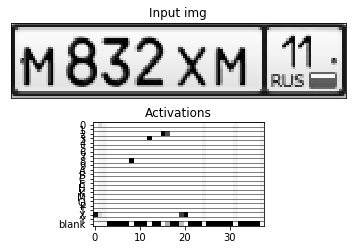

Predicted: X78Y
True: H178YO11


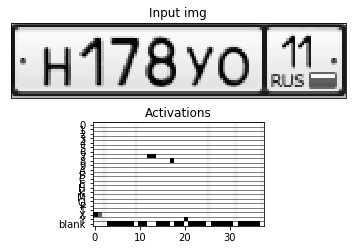

Predicted: X7P8
True: O756PH18


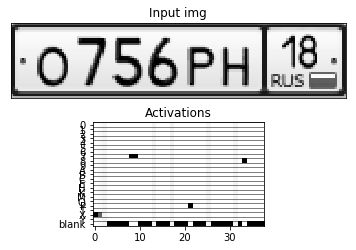

Predicted: X84070
True: O840KB70


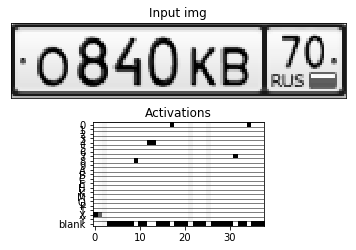

Predicted: XP223X42
True: P223TX42


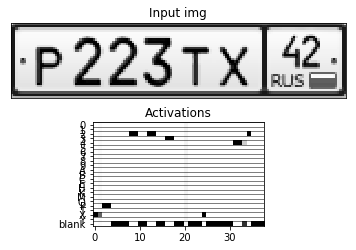

Predicted: X4
True: K545HE91


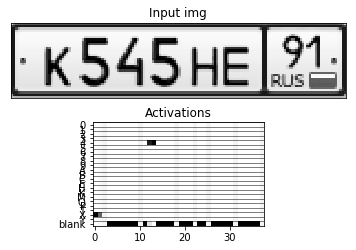

Predicted: X384P
True: T384PK96


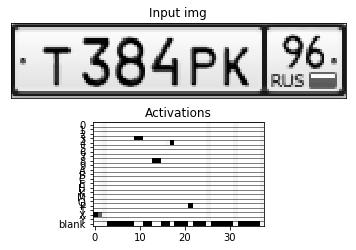

Predicted: X02
True: X111AT02


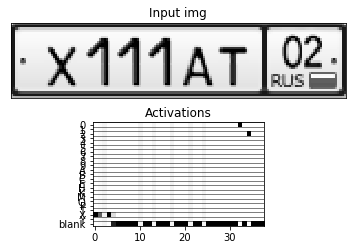

In [289]:
tiger_test = TextImageGenerator(train_test_dataset.train_dataset, img_w, img_h, 8, 4)

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in tiger_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decoding_to_text(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    
    for label in labels:
        text = ''.join(list(map(lambda x: char_list[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        #fig = plt.figure(figsize=(10, 10))
        fig = plt.figure()
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(char_list) + 1)))
        ax2.set_yticklabels(char_list + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(char_list) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        plt.show()
    break